In [1]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [2]:
path = 'dataset/preprocessed/001/bg-01/000/001-bg-01-000-001.png'

In [3]:
img = Image.open(path).convert('L')

In [4]:
def imshow(img):
    plt.imshow(img, cmap="gray")
    plt.axis("off")  # Hide axes
    plt.show()
def view_image_in_layer(img):
    img = img.squeeze(0).squeeze(0)  # Bây giờ x có shape (32, 64, 64)

    num_channels = img.shape[0]
    cols = 8  # Số cột hiển thị, ví dụ 8
    rows = (num_channels + cols - 1) // cols  # Tính số hàng cần thiết
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2*rows))
    axes = axes.flatten()  # Chuyển về dạng 1 chiều
    
    for i in range(num_channels):
        axes[i].imshow(img[i].cpu().detach().numpy(), cmap='gray')
        axes[i].set_title(f"Channel {i}")
        axes[i].axis('off')
    
    # Ẩn các subplot thừa nếu có
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
from model.network.gaitset import SetNet
import torch.nn as nn
import torch.nn.functional as F

In [6]:
m1 = SetNet(256).float()
m1 = nn.DataParallel(m1).cuda()

m2 = SetNet(256).float()
m2 = nn.DataParallel(m2).cuda()

In [7]:
import os.path as osp

model_name = 'GaitSet'
resotre_iter = 39500
m2.load_state_dict(torch.load(osp.join(
            'work',
            'checkpoint', model_name,
            'GaitSet_CASIA-B_73_False_256_0.2_128_full_30-108100-encoder.ptm')))

<All keys matched successfully>

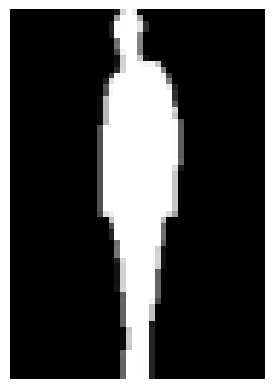

torch.Size([1, 64, 44])

In [8]:
transform = transforms.ToTensor()
img = img.resize((44, 64))
imshow(img)
img_tensor = transform(img)
img_tensor.shape

In [9]:
n = img_tensor.size(0)
x = img_tensor.unsqueeze(0)
x = x.unsqueeze(0).cuda()

In [10]:
x.size()

torch.Size([1, 1, 1, 64, 44])

## C1 (1, 1, 64, 44) * (32, 1, 5, 5) -> (1, 32, 64, 44) (padding 2)

output_size = ((input_size + 2×padding - kernel_size) / stride) + 1 (default stride = 1)

torch.Size([1, 1, 32, 64, 44])


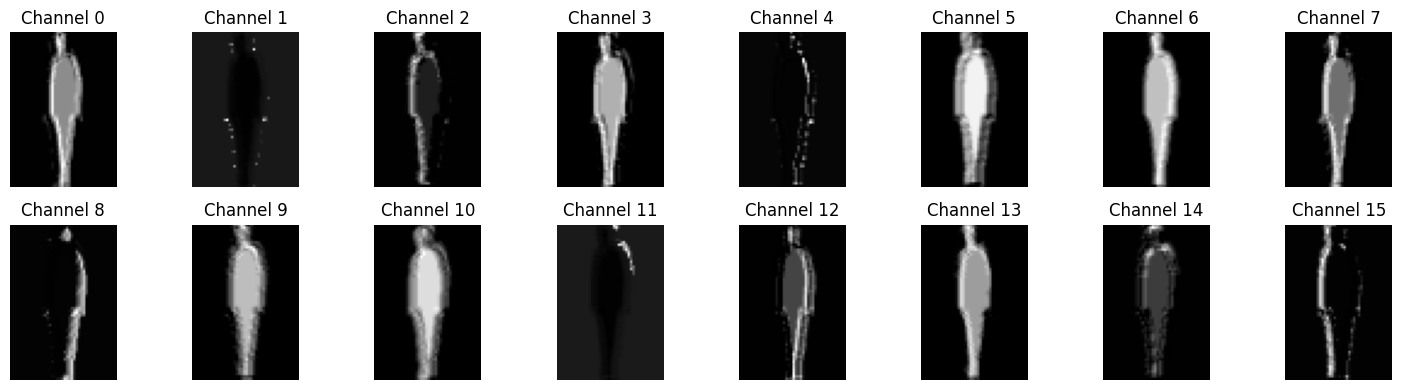

torch.Size([1, 1, 32, 64, 44])


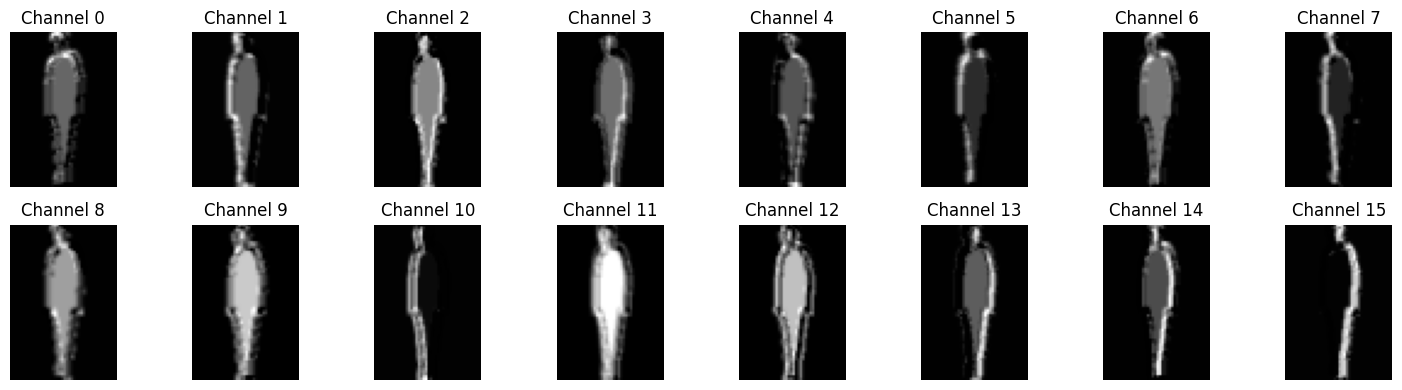

In [11]:
img_layer1_m1 = m1.module.set_layer1(x)
print(img_layer1_m1.shape)
view_image_in_layer(img_layer1_m1[:, :, :16])

img_layer1_m2 = m2.module.set_layer1(x)
print(img_layer1_m2.shape)
view_image_in_layer(img_layer1_m2[:, :, :16])

In [12]:
def view_kernel_in_layer(model, layer_name):
    layer = dict(model.module.named_modules())[layer_name]

    kernel_1s = None
    for name, param in layer.named_parameters():
        if "weight" in name:
            kernel_1s = param
            
    tensor_normalized = ((kernel_1s + 1) / 2) * 255
    tensor_normalized = tensor_normalized.clamp(0, 255).to(torch.uint8).cpu()

    scale_factor = 20  # Change this for bigger images
    upsampled_tensor = F.interpolate(tensor_normalized.float(), scale_factor=scale_factor, mode="nearest")

    # Convert to NumPy
    np_tensor = upsampled_tensor.numpy()

    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(np_tensor[i][0], cmap="gray")
        plt.axis("off")
    plt.show()

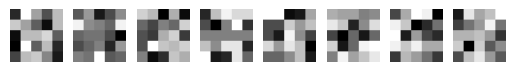

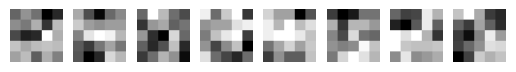

In [13]:
view_kernel_in_layer(m1, 'set_layer1')
view_kernel_in_layer(m2, 'set_layer1')

## C2 (1, 32, 66, 44) * (32, 32, 3, 3) -> (1, 32, 32, 22) (padding 1, downsampling)

torch.Size([1, 1, 32, 64, 44])


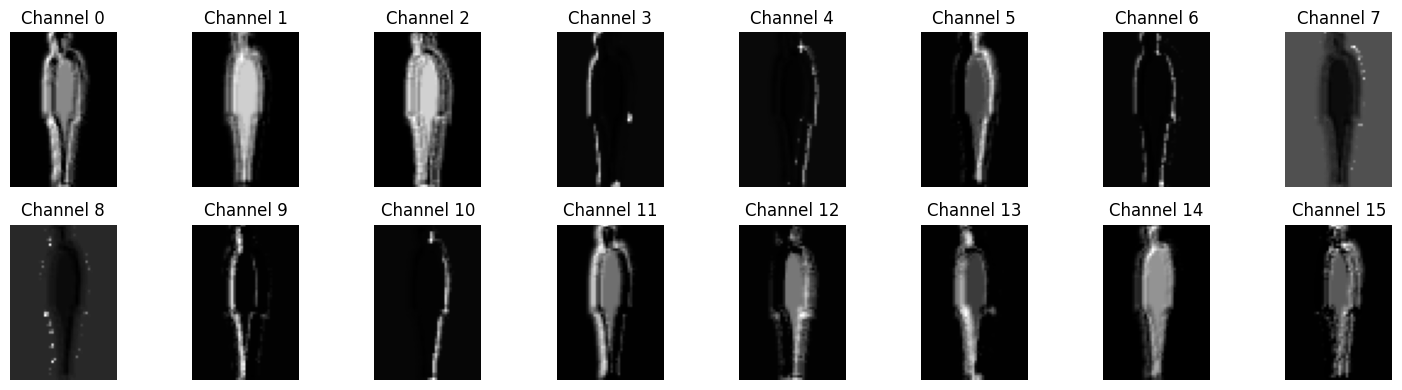

torch.Size([1, 1, 32, 64, 44])


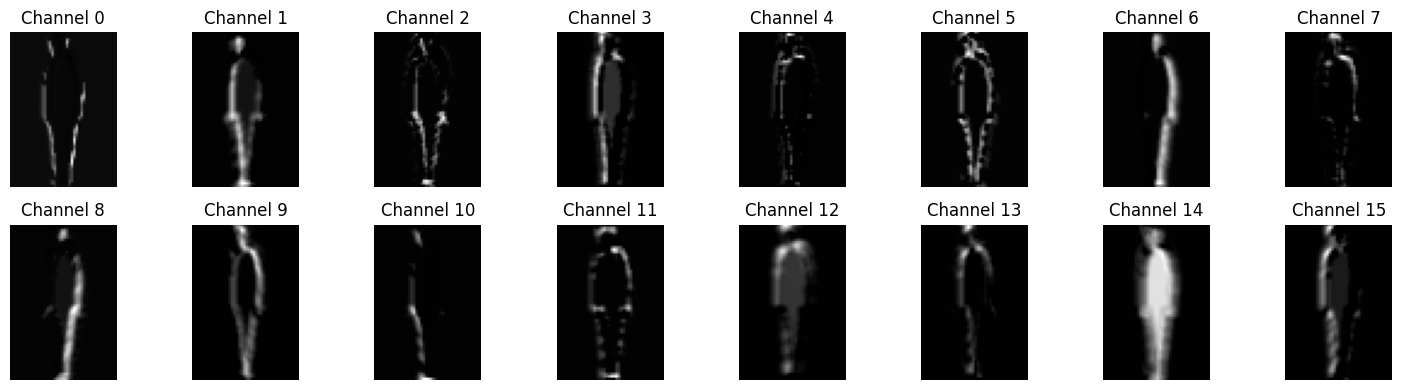

In [14]:
img_layer2_m1 = m1.module.set_layer2(img_layer1_m1)
print(img_layer2_m1.shape)
view_image_in_layer(img_layer2_m1[:, :, :16])

img_layer2_m2 = m2.module.set_layer2(img_layer1_m2)
print(img_layer2_m2.shape)
view_image_in_layer(img_layer2_m2[:, :, :16])

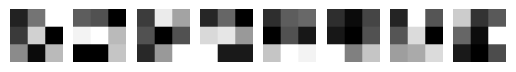

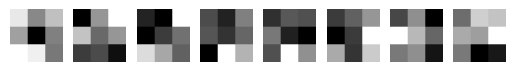

In [15]:
view_kernel_in_layer(m1, 'set_layer2')
view_kernel_in_layer(m2, 'set_layer2')

# SP (1, 32, 32, 22)

torch.Size([1, 32, 64, 44])


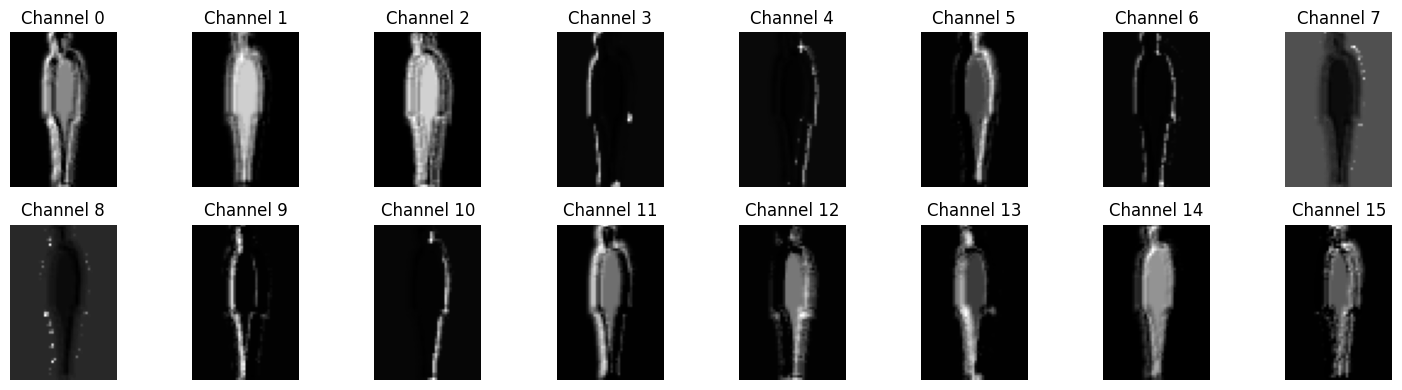

torch.Size([1, 32, 64, 44])


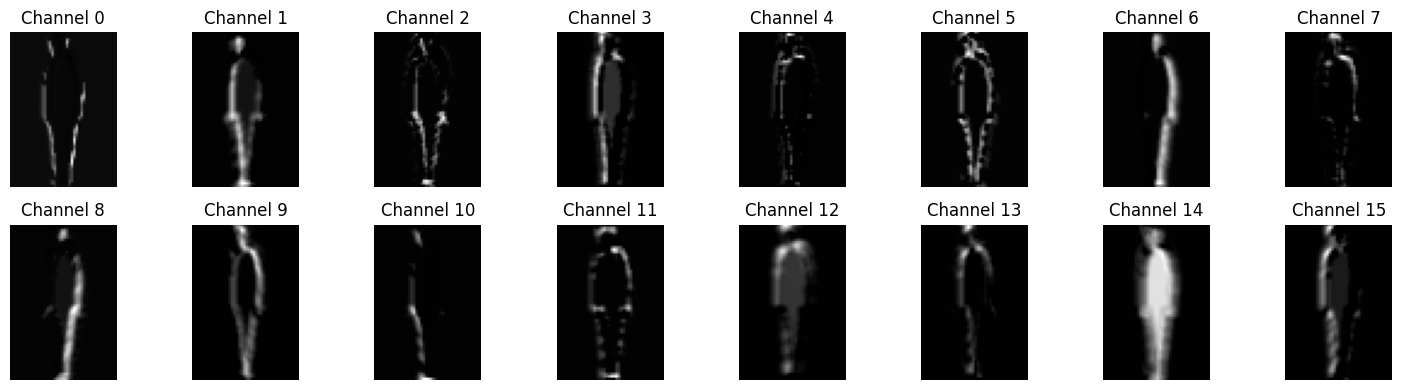

In [16]:
frame_max_2_m1 = m1.module.frame_max(img_layer2_m1)
print(frame_max_2_m1[0].shape)
view_image_in_layer(frame_max_2_m1[0][:, :16])

frame_max_2_m2 = m2.module.frame_max(img_layer2_m2)
print(frame_max_2_m2[0].shape)
view_image_in_layer(frame_max_2_m2[0][:, :16])

# (1, 32, 32, 22) * (64, 32, 3, 3) -> (1, 64, 32, 22) (padding 1)

torch.Size([1, 64, 64, 44])


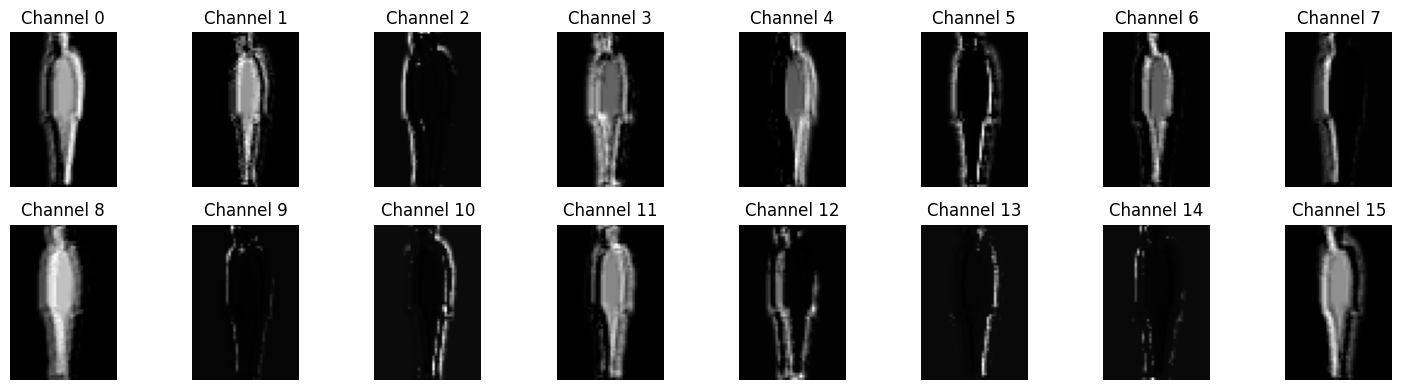

torch.Size([1, 64, 64, 44])


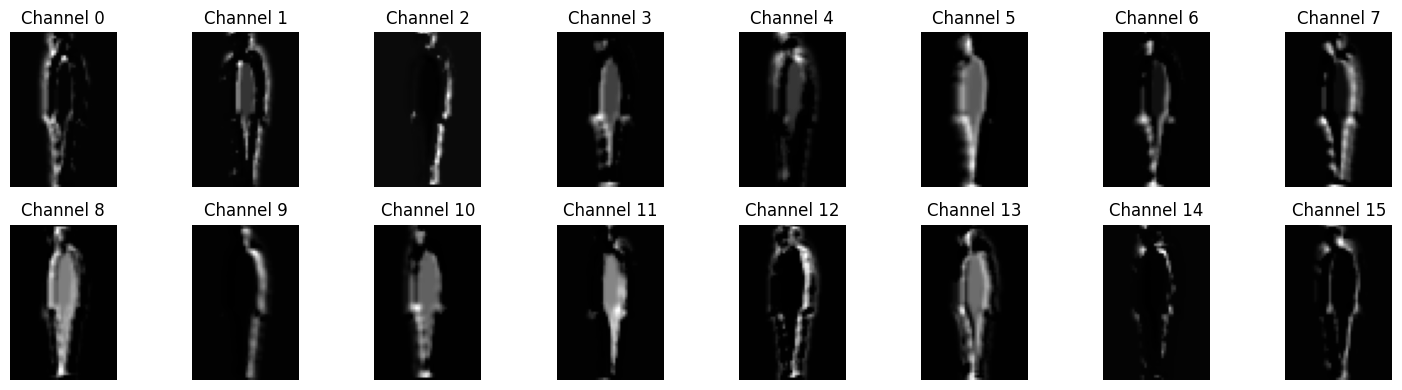

In [17]:
img_gl_layer1_m1 = m1.module.gl_layer1(frame_max_2_m1[0])
print(img_gl_layer1_m1.shape)
view_image_in_layer(img_gl_layer1_m1[:, :16])

img_gl_layer1_m2 = m2.module.gl_layer1(frame_max_2_m2[0])
print(img_gl_layer1_m2.shape)
view_image_in_layer(img_gl_layer1_m2[:, :16])


# (1, 64, 32, 32) * (64, 64, 3, 3) -> (1, 64, 32, 32) (padding 1)

torch.Size([1, 64, 64, 44])


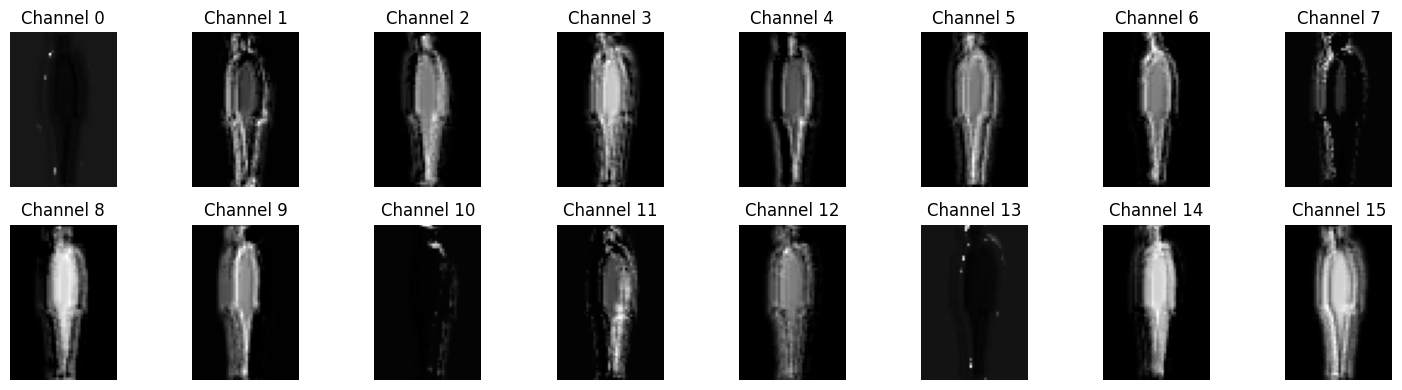

torch.Size([1, 64, 64, 44])


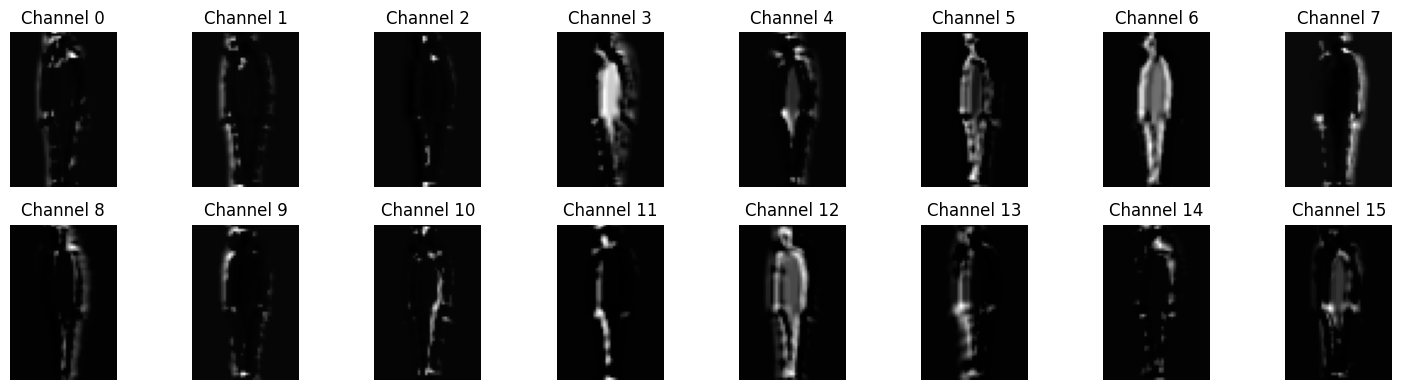

In [18]:
img_gl_layer2_m1 = m1.module.gl_layer2(img_gl_layer1_m1)
print(img_gl_layer2_m1.shape)
view_image_in_layer(img_gl_layer2_m1[:, :16])

img_gl_layer2_m2 = m2.module.gl_layer2(img_gl_layer1_m2)
print(img_gl_layer2_m2.shape)  
view_image_in_layer(img_gl_layer2_m2[:, :16])

 # Pooling (1, 64, 16, 16)

torch.Size([1, 64, 32, 22])


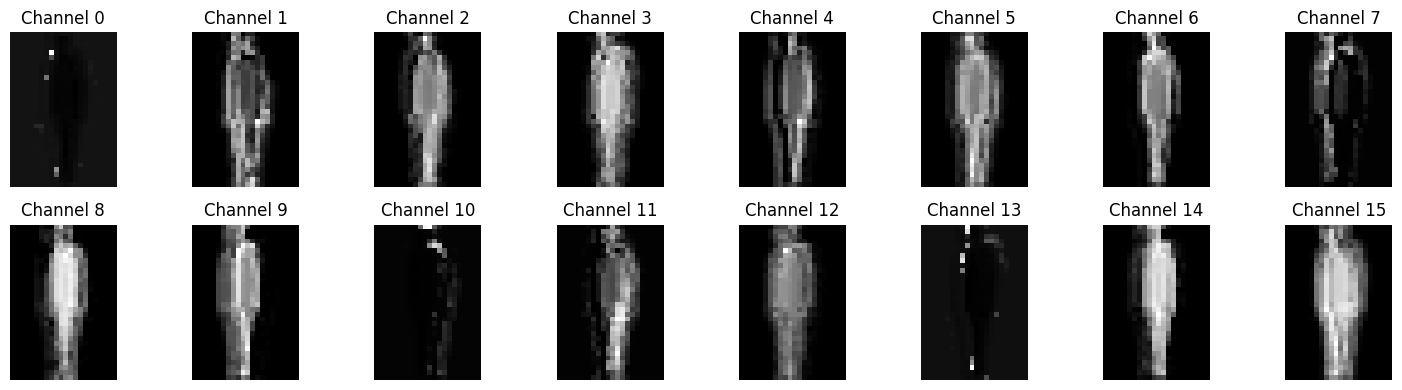

torch.Size([1, 64, 32, 22])


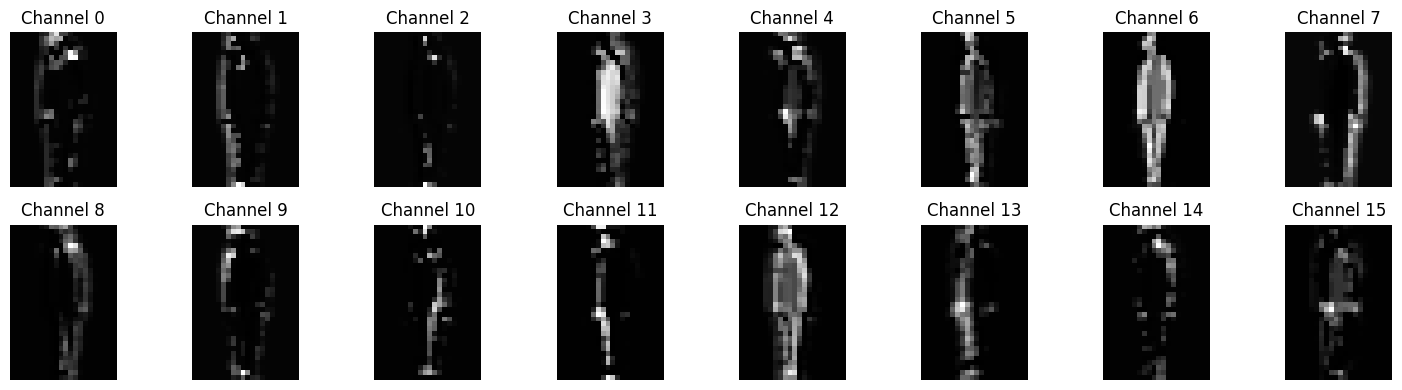

In [19]:
gl_pool_m1 = m1.module.gl_pooling(img_gl_layer2_m1)
print(gl_pool_m1.shape)
view_image_in_layer(gl_pool_m1[:, :16])

gl_pool_m2 = m2.module.gl_pooling(img_gl_layer2_m2)
print(gl_pool_m2.shape) 
view_image_in_layer(gl_pool_m2[:, :16])

# C3 (1, 32, 32, 32) * (64, 32, 3, 3) -> (1, 64, 32, 32) (padding 1)

torch.Size([1, 1, 64, 64, 44])


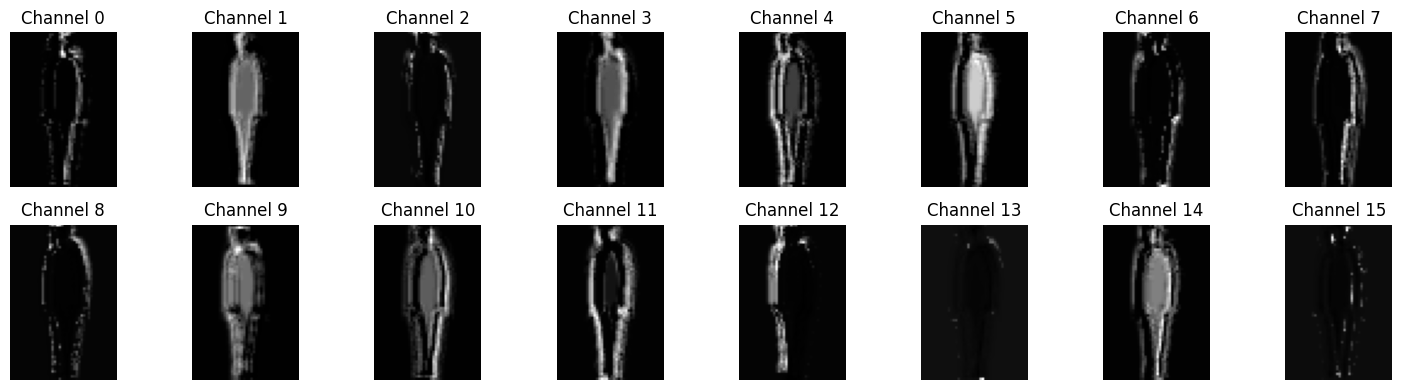

torch.Size([1, 1, 64, 64, 44])


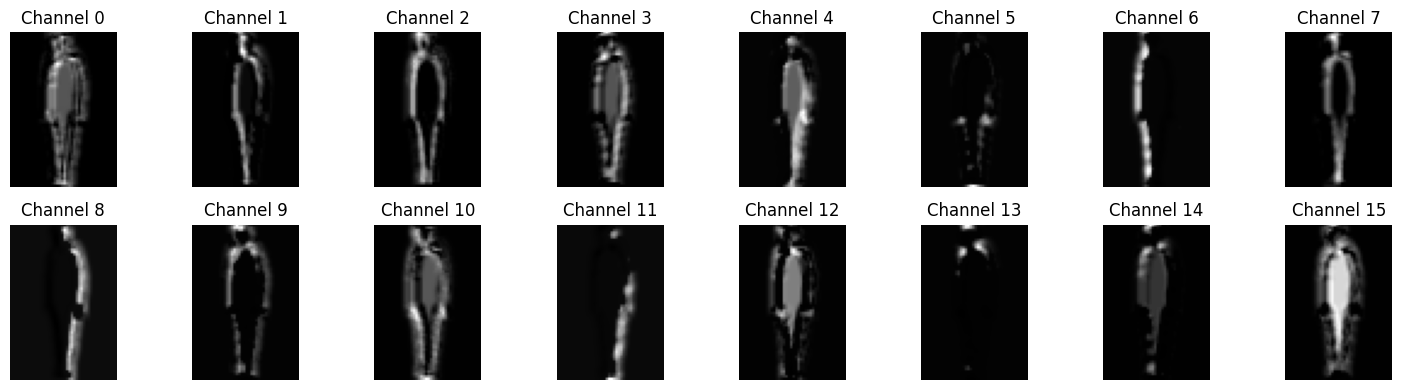

In [20]:
img_layer3_m1 = m1.module.set_layer3(img_layer2_m1)
print(img_layer3_m1.shape)
view_image_in_layer(img_layer3_m1[:, :, :16])

img_layer3_m2 = m2.module.set_layer3(img_layer2_m2)
print(img_layer3_m2.shape)
view_image_in_layer(img_layer3_m2[:, :, :16])

# C4 (1, 64, 22, 32) * (64, 64, 3, 3) -> (1, 64, 11, 16) (padding1, downsampling)

torch.Size([1, 1, 64, 32, 22])


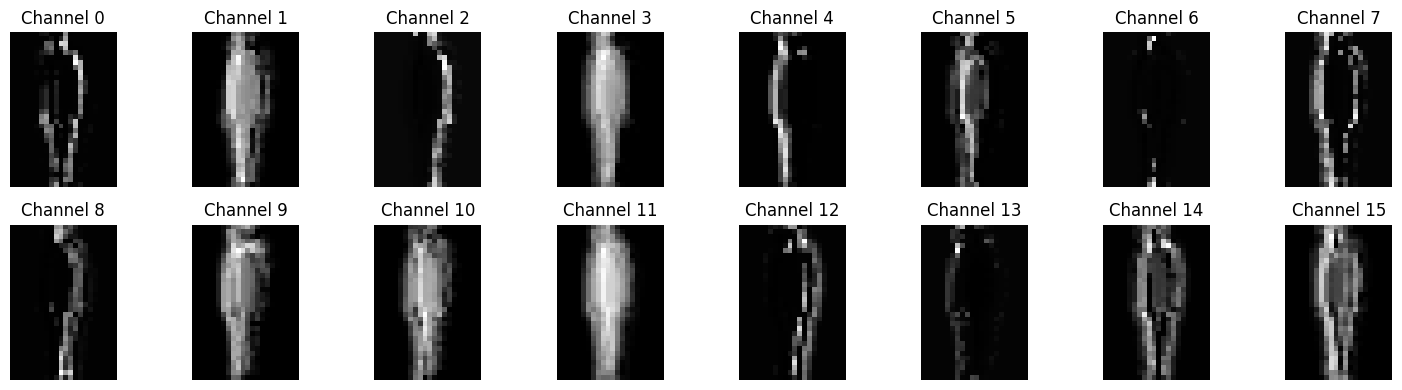

torch.Size([1, 1, 64, 32, 22])


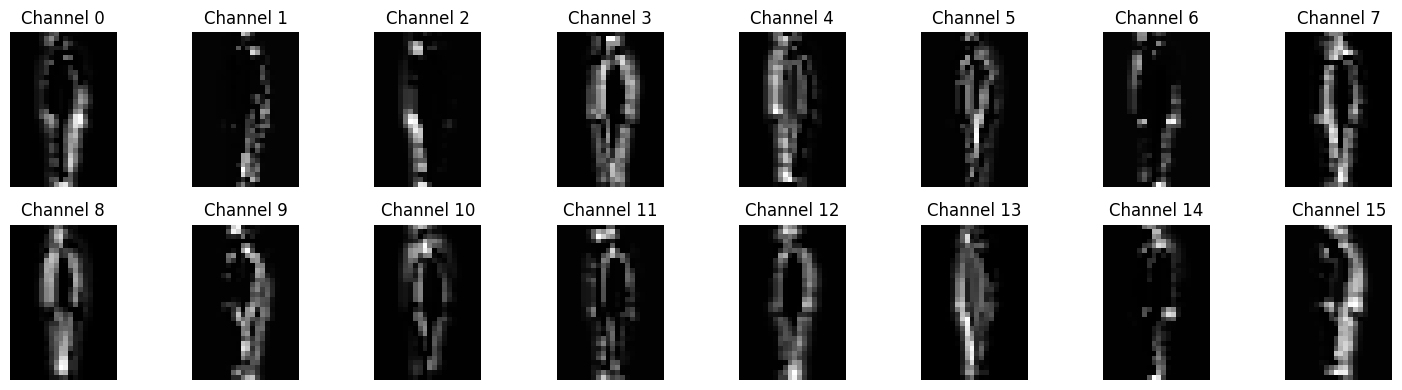

In [21]:
img_layer4_m1 = m1.module.set_layer4(img_layer3_m1)
print(img_layer4_m1.shape)
view_image_in_layer(img_layer4_m1[:, :, :16])

img_layer4_m2 = m2.module.set_layer4(img_layer3_m2)
print(img_layer4_m2.shape)
view_image_in_layer(img_layer4_m2[:, :, :16])

# SP (1, 64, 16, 16)

torch.Size([1, 64, 32, 22])


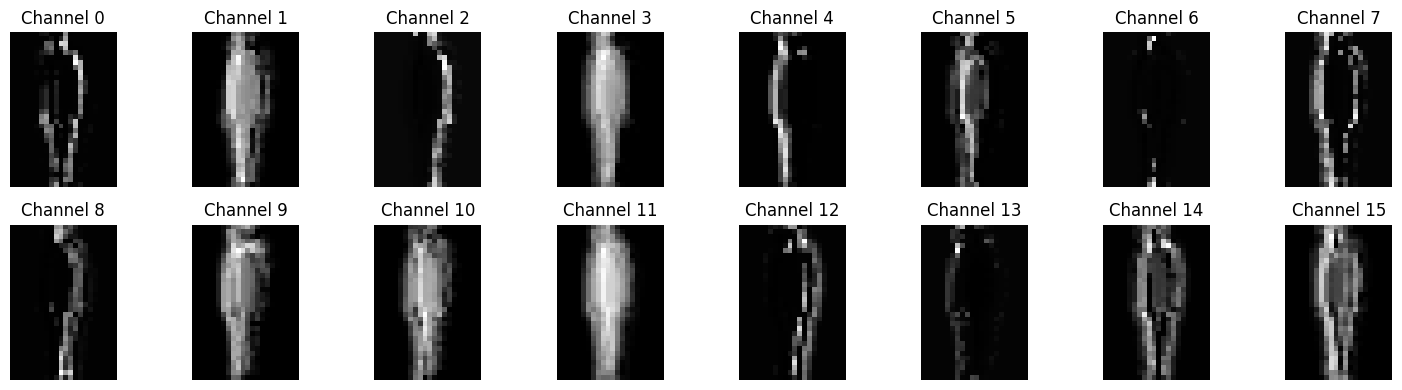

torch.Size([1, 64, 32, 22])


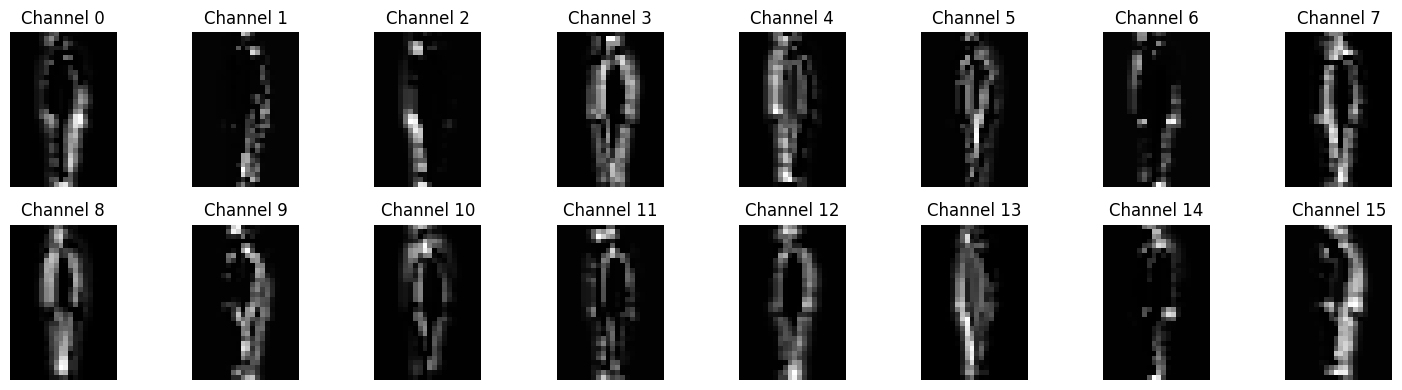

In [22]:
frame_max_4_m1 = m1.module.frame_max(img_layer4_m1)
print(frame_max_4_m1[0].shape)
view_image_in_layer(frame_max_4_m1[0][:, :16])

frame_max_4_m2 = m2.module.frame_max(img_layer4_m2)
print(frame_max_4_m2[0].shape)
view_image_in_layer(frame_max_4_m2[0][:, :16])

# (1, 64, 16, 16) * (128, 64, 3, 3) -> (1, 128, 16, 16) (pading 1) 

torch.Size([1, 128, 32, 22])


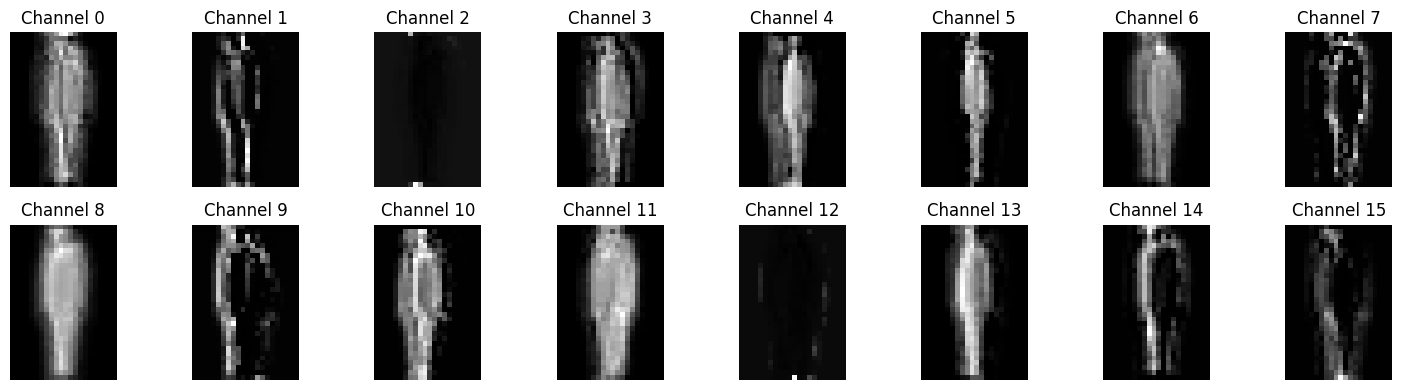

torch.Size([1, 128, 32, 22])


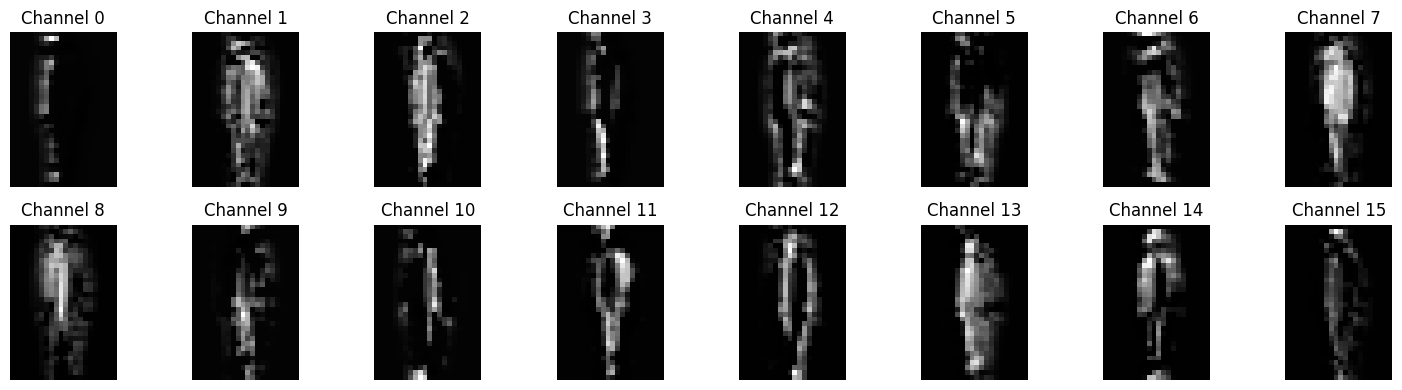

In [23]:
img_gl_layer3_m1 = m1.module.gl_layer3(gl_pool_m1 + frame_max_4_m1[0])
print(img_gl_layer3_m1.shape)
view_image_in_layer(img_gl_layer3_m1[:, :16])

img_gl_layer3_m2 = m2.module.gl_layer3(gl_pool_m2 + frame_max_4_m2[0])
print(img_gl_layer3_m2.shape)
view_image_in_layer(img_gl_layer3_m2[:, :16])

# (1, 128, 16, 16) * (128, 128, 3, 3) -> (1, 128, 16, 16) (padding 1)

torch.Size([1, 128, 32, 22])


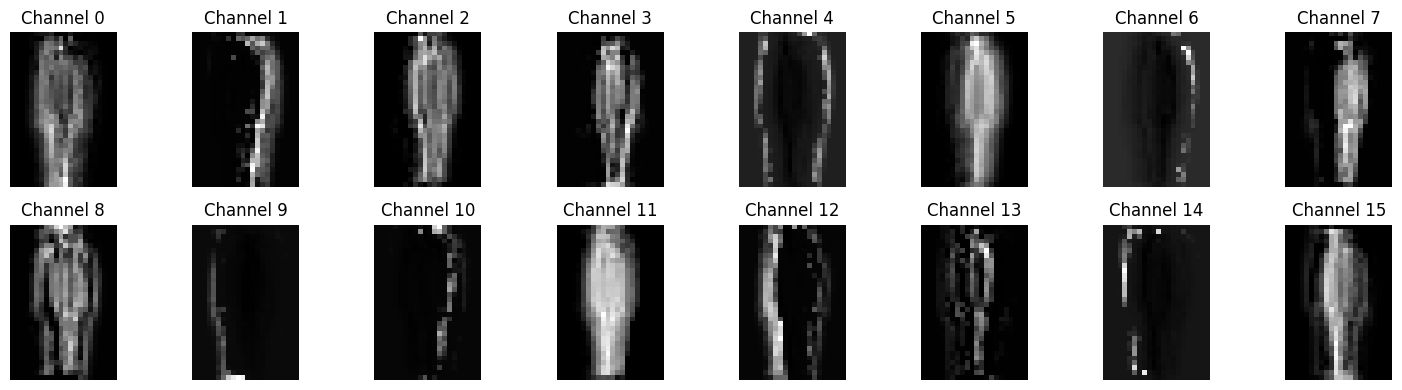

torch.Size([1, 128, 32, 22])


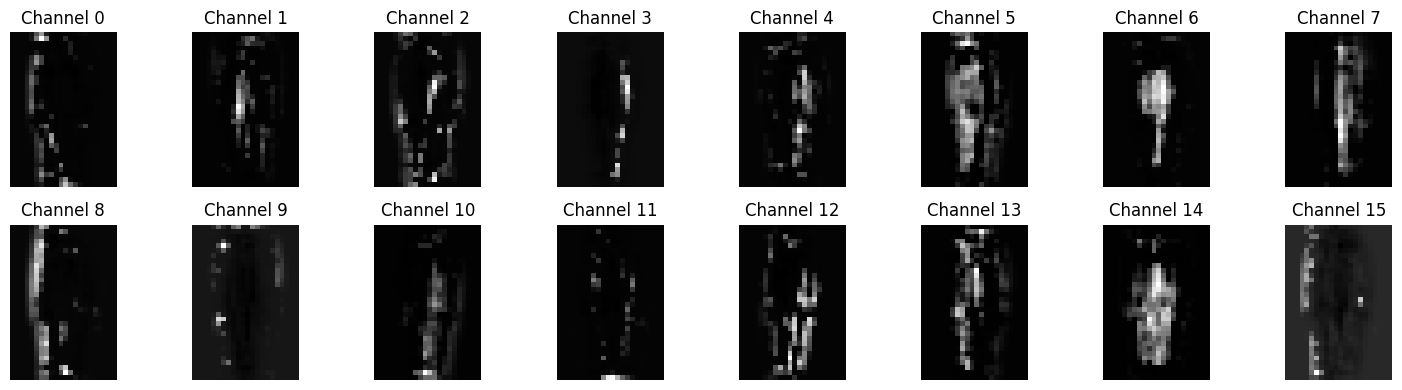

In [24]:
img_gl_layer4_m1 = m1.module.gl_layer4(img_gl_layer3_m1)
print(img_gl_layer4_m1.shape)
view_image_in_layer(img_gl_layer4_m1[:, :16])

img_gl_layer4_m2 = m2.module.gl_layer4(img_gl_layer3_m2)
print(img_gl_layer4_m2.shape)
view_image_in_layer(img_gl_layer4_m2[:, :16])

# C5 (1, 64, 16, 16) * (128, 64, 3, 3) -> (1, 128, 16, 16) (padding 1) 

torch.Size([1, 1, 128, 32, 22])


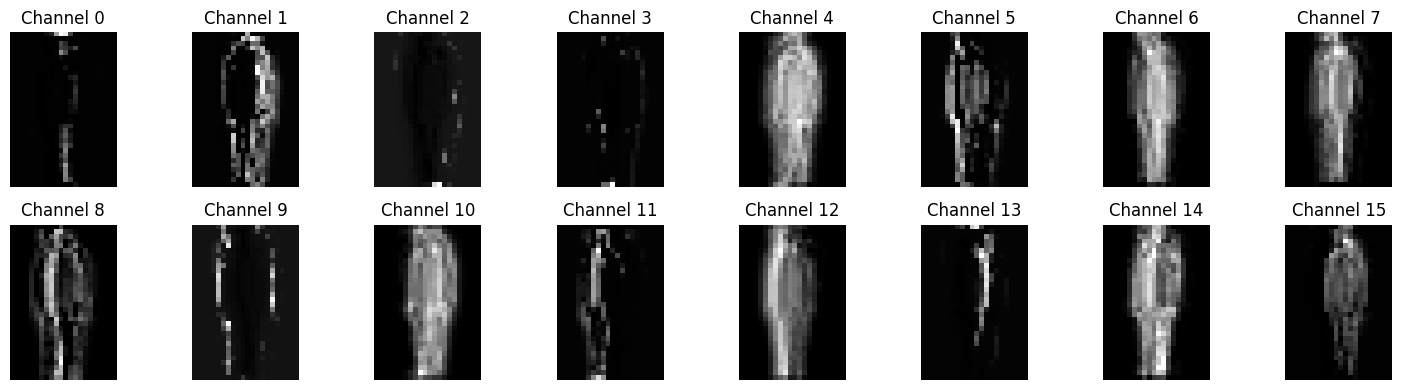

torch.Size([1, 1, 128, 32, 22])


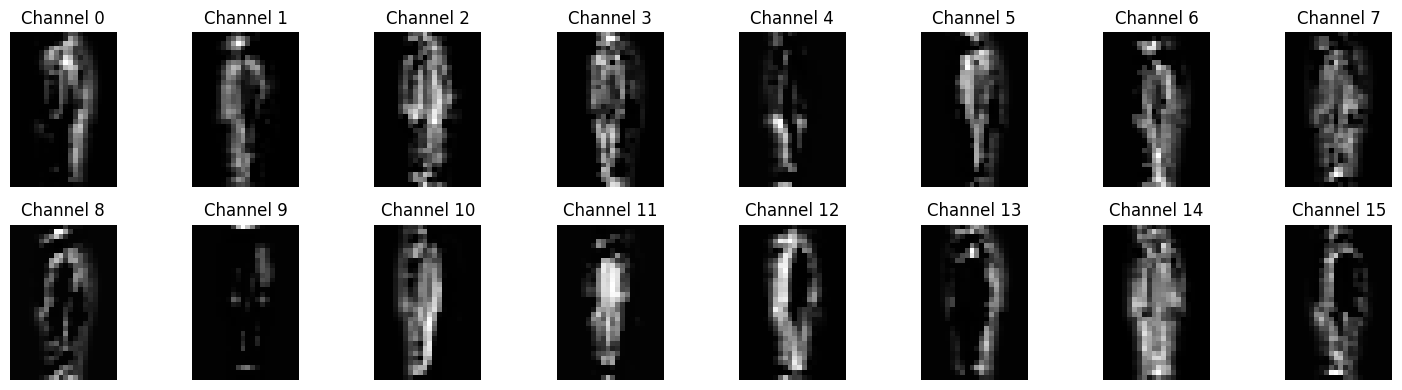

In [25]:
img_layer5_m1 = m1.module.set_layer5(img_layer4_m1)
print(img_layer5_m1.shape)
view_image_in_layer(img_layer5_m1[:, :, :16])

img_layer5_m2 = m2.module.set_layer5(img_layer4_m2)
print(img_layer5_m2.shape)
view_image_in_layer(img_layer5_m2[:, :, :16])

# C6 (1, 128, 16, 16) * (128, 128, 16, 16) -> (1, 128 ,16, 16) (padding 1)

torch.Size([1, 1, 128, 32, 22])


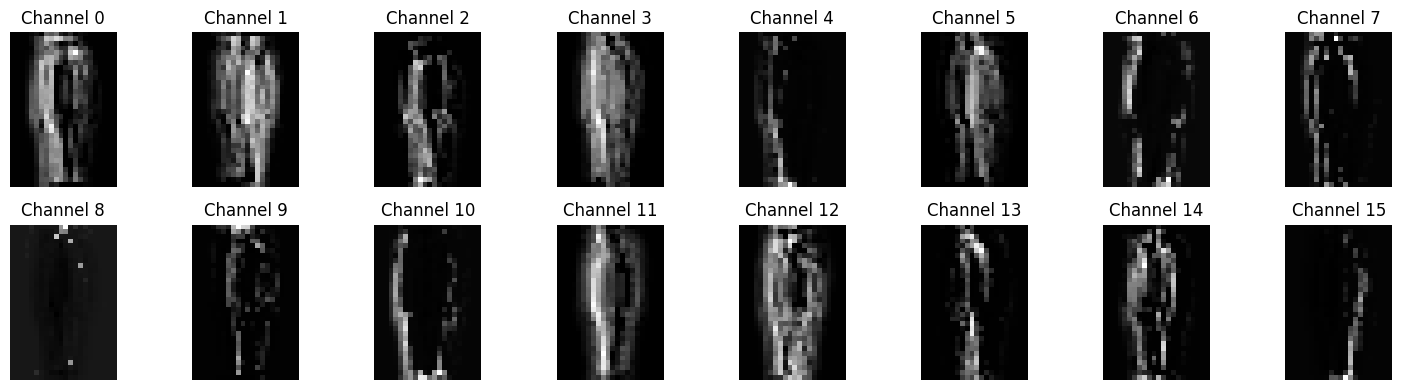

torch.Size([1, 1, 128, 32, 22])


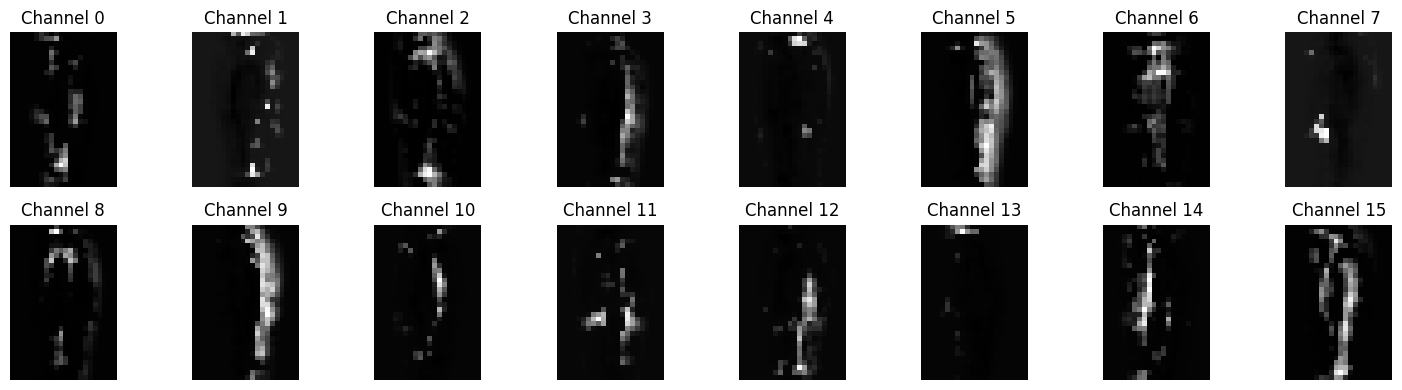

In [26]:
img_layer6_m1 = m1.module.set_layer6(img_layer5_m1)
print(img_layer6_m1.shape)
view_image_in_layer(img_layer6_m1[:, :, :16])

img_layer6_m2 = m2.module.set_layer6(img_layer5_m2)
print(img_layer6_m2.shape)
view_image_in_layer(img_layer6_m2[:, :, :16])

# SP (1, 128, 16, 16)

torch.Size([1, 128, 32, 22])


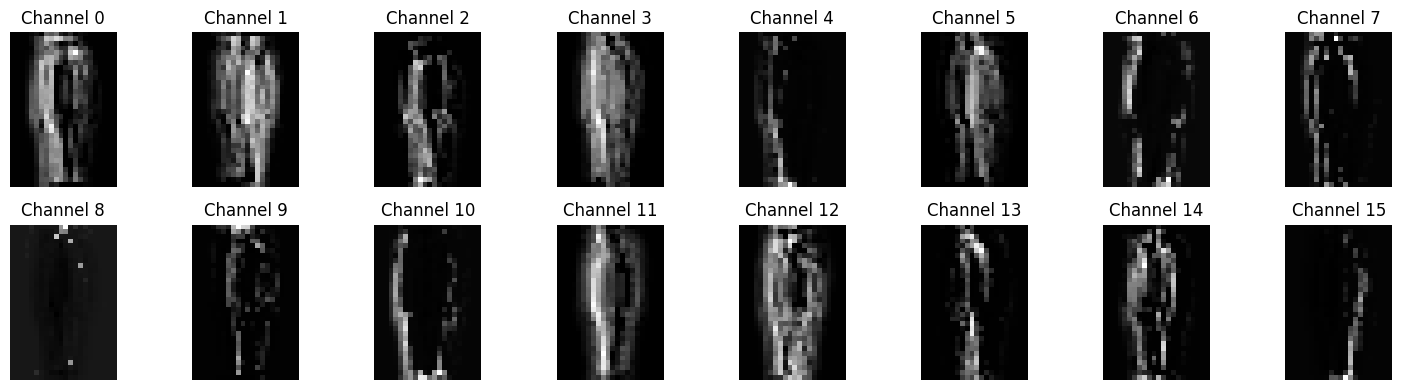

torch.Size([1, 128, 32, 22])


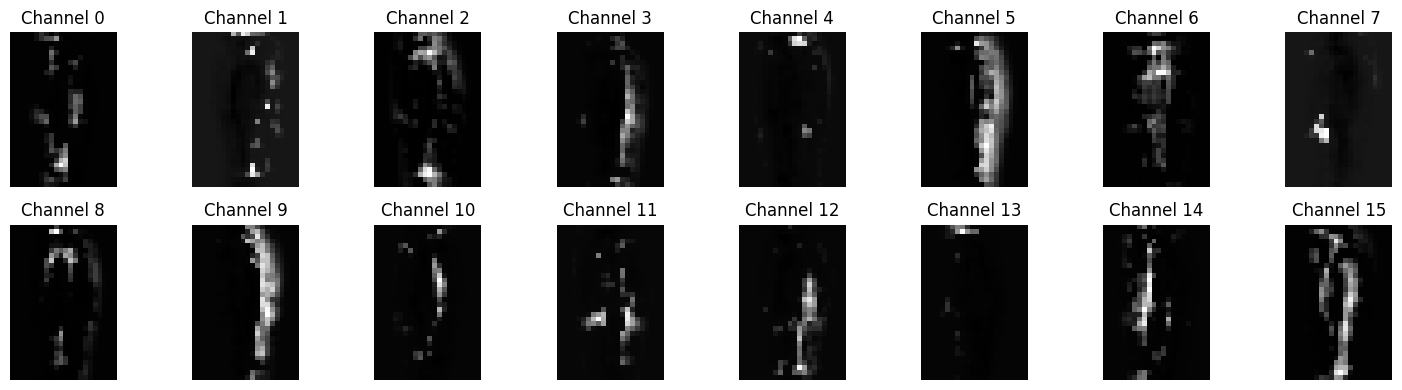

In [27]:
frame_max_6_m1 = m1.module.frame_max(img_layer6_m1)
print(frame_max_6_m1[0].shape)
view_image_in_layer(frame_max_6_m1[0][:, :16])

frame_max_6_m2 = m2.module.frame_max(img_layer6_m2)
print(frame_max_6_m2[0].shape)
view_image_in_layer(frame_max_6_m2[0][:, :16])

torch.Size([1, 128, 32, 22])


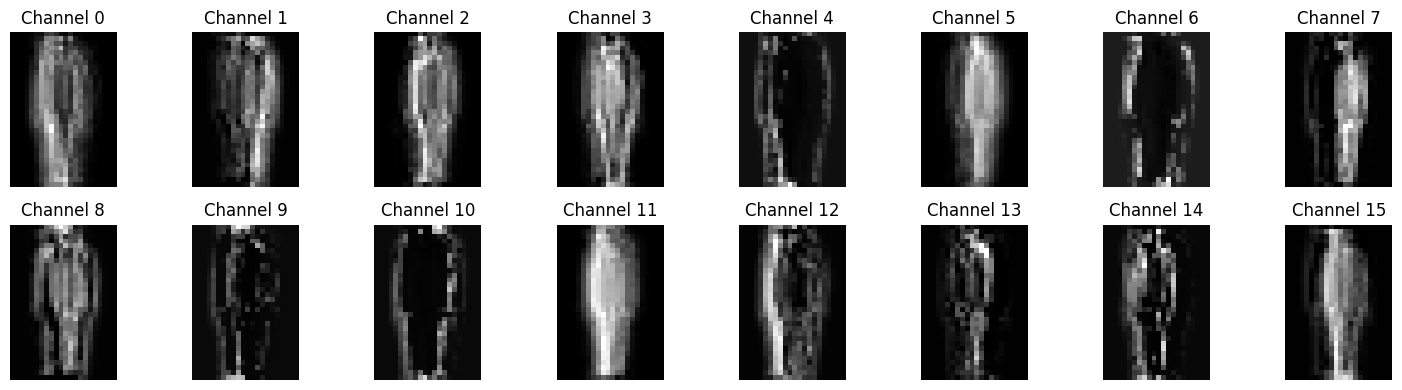

torch.Size([1, 128, 32, 22])


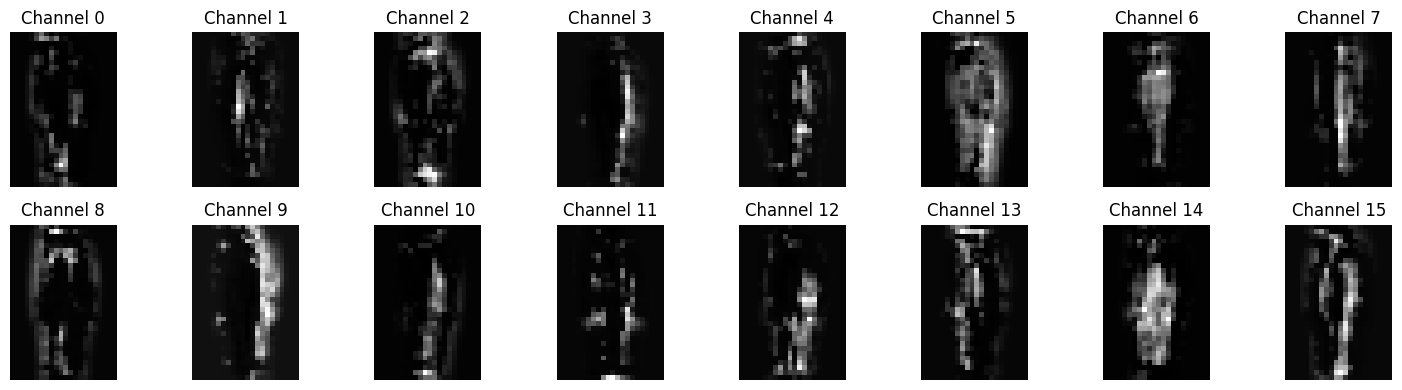

In [33]:
X_m1 = frame_max_6_m1[0]
gl_m1 = X_m1 + img_gl_layer4_m1
print(gl_m1.shape)
view_image_in_layer(gl_m1[:, :16])

X_m2 = frame_max_6_m2[0]
gl_m2 = X_m2 + img_gl_layer4_m2
print(gl_m2.shape)
view_image_in_layer(gl_m2[:, :16])

In [29]:
features_m1 = list()
n, c, h, w = gl_m1.size()
for num_bin in m1.module.bin_num:
    z_m1 = X_m1.view(n, c, num_bin, -1)
    z_m1 = z_m1.mean(3) + z_m1.max(3)[0]
    features_m1.append(z_m1)
    z_m1 = gl_m1.view(n, c, num_bin, -1)
    z_m1 = z_m1.mean(3) + z_m1.max(3)[0]
    features_m1.append(z_m1)

features_m1 = torch.cat(features_m1, 2)
# print(features_m1.size())
features_m1 = features_m1.permute(2, 0, 1)
# print(features_m1.size())
features_m1 = features_m1.contiguous()
# print(features_m1.size())
# print(features_m1)
# print(m1.module.fc_bin[0].size())
features_m1 = features_m1.matmul(m1.module.fc_bin[0])
# print(features_m1.shape)
# print(feature)
features_m1 = features_m1.permute(1, 0, 2).contiguous()
print(features_m1.shape)

features_m2 = list()
n, c, h, w = gl_m2.size()
for num_bin in m2.module.bin_num:
    z_m2 = X_m2.view(n, c, num_bin, -1)
    z_m2 = z_m2.mean(3) + z_m2.max(3)[0]
    features_m2.append(z_m2)
    z_m2 = gl_m2.view(n, c, num_bin, -1)
    z_m2 = z_m2.mean(3) + z_m2.max(3)[0]
    features_m2.append(z_m2)
features_m2 = torch.cat(features_m2, 2)
features_m2 = features_m2.permute(2, 0, 1)
features_m2 = features_m2.contiguous()
features_m2 = features_m2.matmul(m2.module.fc_bin[0])
features_m2 = features_m2.permute(1, 0, 2).contiguous()
print(features_m2.shape)

torch.Size([1, 62, 256])
torch.Size([1, 62, 256])


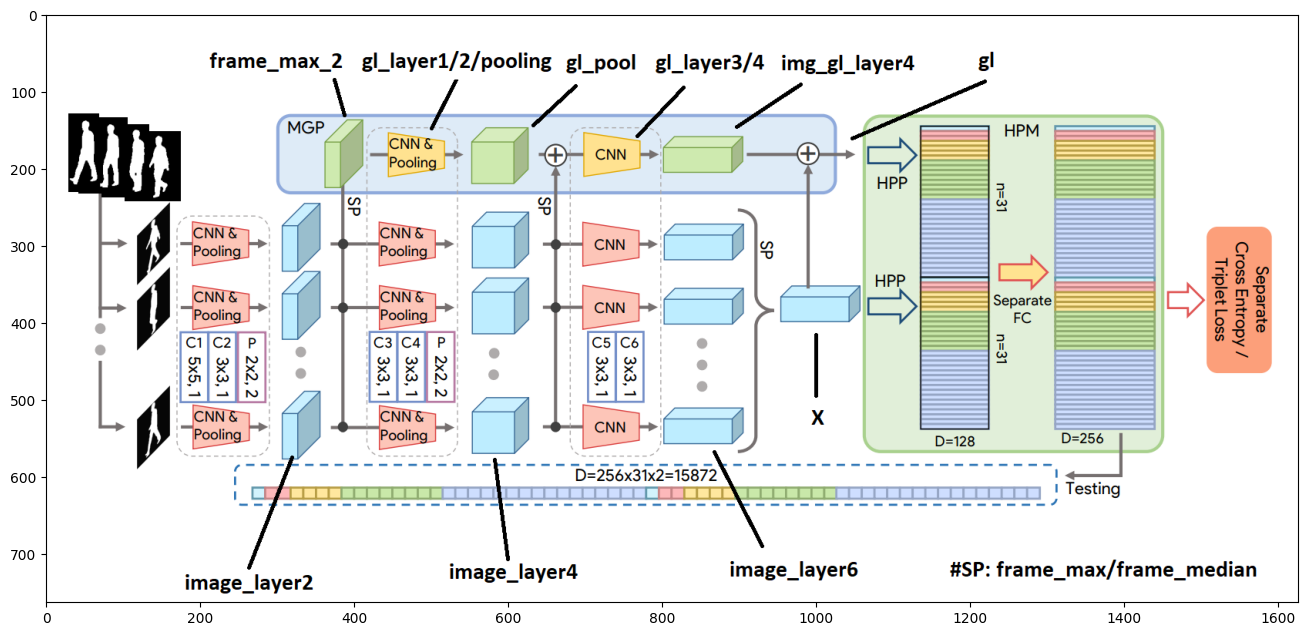

In [30]:
flow = Image.open('Capture.png')
plt.figure(figsize=(flow.width / 100, flow.height / 100), dpi=100)
plt.imshow(flow)

In [59]:
folder_path = 'dataset/preprocessed/001/bg-01/000'

img_array = []

for i in range(1, 65):
    img_path = f'{folder_path}/001-bg-01-000-{i:03d}.png'
    img = Image.open(img_path).convert('L')
    img = img.resize((44, 64))
    img_array.append(img)
img_array = torch.stack([transform(img) for img in img_array]).cuda()
img_array = img_array.view(1, 64, 44, 64)

In [62]:
features_pack = m2.module(img_array)

In [65]:
features_pack[0].shape

torch.Size([1, 62, 256])

In [66]:
features_pack

(tensor([[[ 0.0435,  0.0069,  0.1321,  ..., -0.1062,  0.1794, -0.2554],
          [ 0.4653,  0.1873, -0.0482,  ...,  0.2708, -0.4441, -0.4502],
          [-0.0105,  0.0596,  0.2952,  ...,  0.0891,  0.3365,  0.1126],
          ...,
          [ 0.0958,  0.1268, -0.0504,  ..., -0.0514, -0.0028, -0.1741],
          [ 0.0738, -0.0188,  0.1107,  ...,  0.0336,  0.1350,  0.0714],
          [ 0.0222, -0.0146,  0.0454,  ...,  0.1246, -0.0565,  0.2701]]],
        device='cuda:0', grad_fn=<PermuteBackward0>),
 None)